АНАЛИЗ: SAR_1

 Гауссовский шум 
PSNR исходного: 6.06 dB

Топ-5 фильтров:
1. gauss_7x7_s1.5: PSNR = 7.91 dB, SSIM = 0.2939
2. gauss_5x5_s2: PSNR = 7.90 dB, SSIM = 0.2850
3. nlm_h20: PSNR = 7.85 dB, SSIM = 0.1794
4. gauss_5x5_s1: PSNR = 7.83 dB, SSIM = 0.2860
5. gauss_3x3_s1: PSNR = 7.73 dB, SSIM = 0.2670


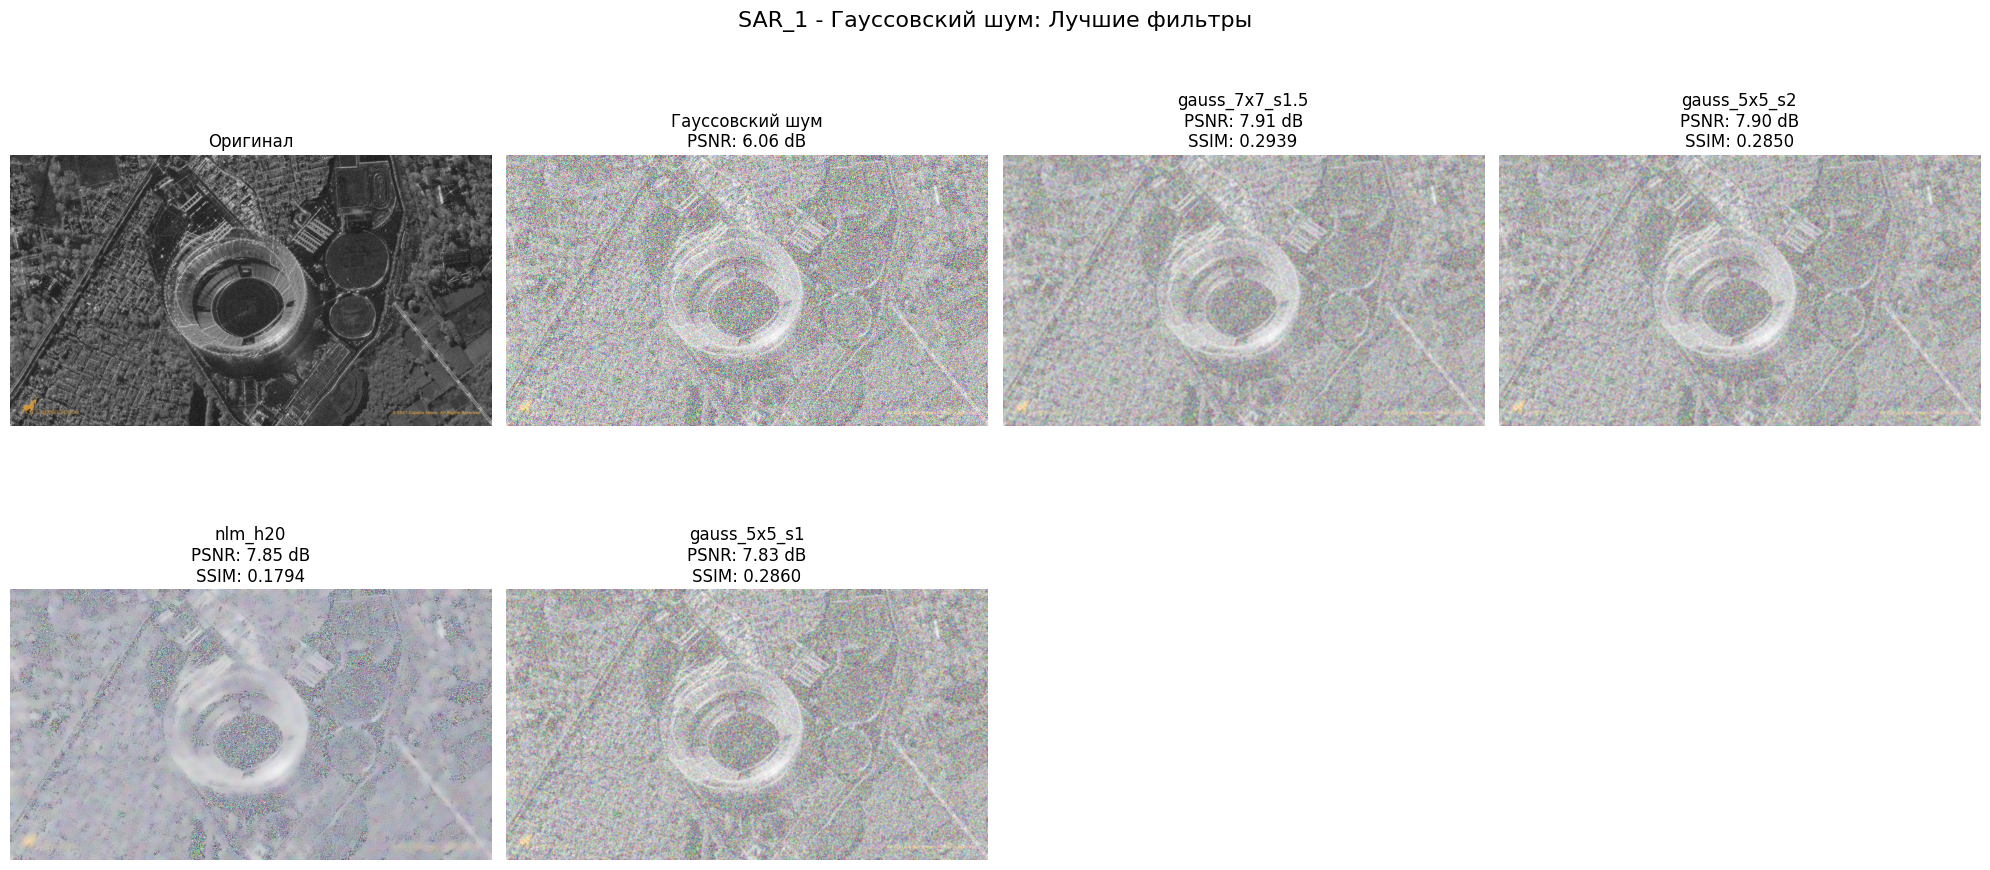


 Солевой-перечный шум 
PSNR исходного: 15.37 dB

Топ-5 фильтров:
1. median_3x3: PSNR = 27.78 dB, SSIM = 0.8019
2. median_5x5: PSNR = 25.13 dB, SSIM = 0.6282
3. median_7x7: PSNR = 23.92 dB, SSIM = 0.5200
4. gauss_7x7_s1.5: PSNR = 23.66 dB, SSIM = 0.5582
5. gauss_5x5_s2: PSNR = 23.49 dB, SSIM = 0.5414


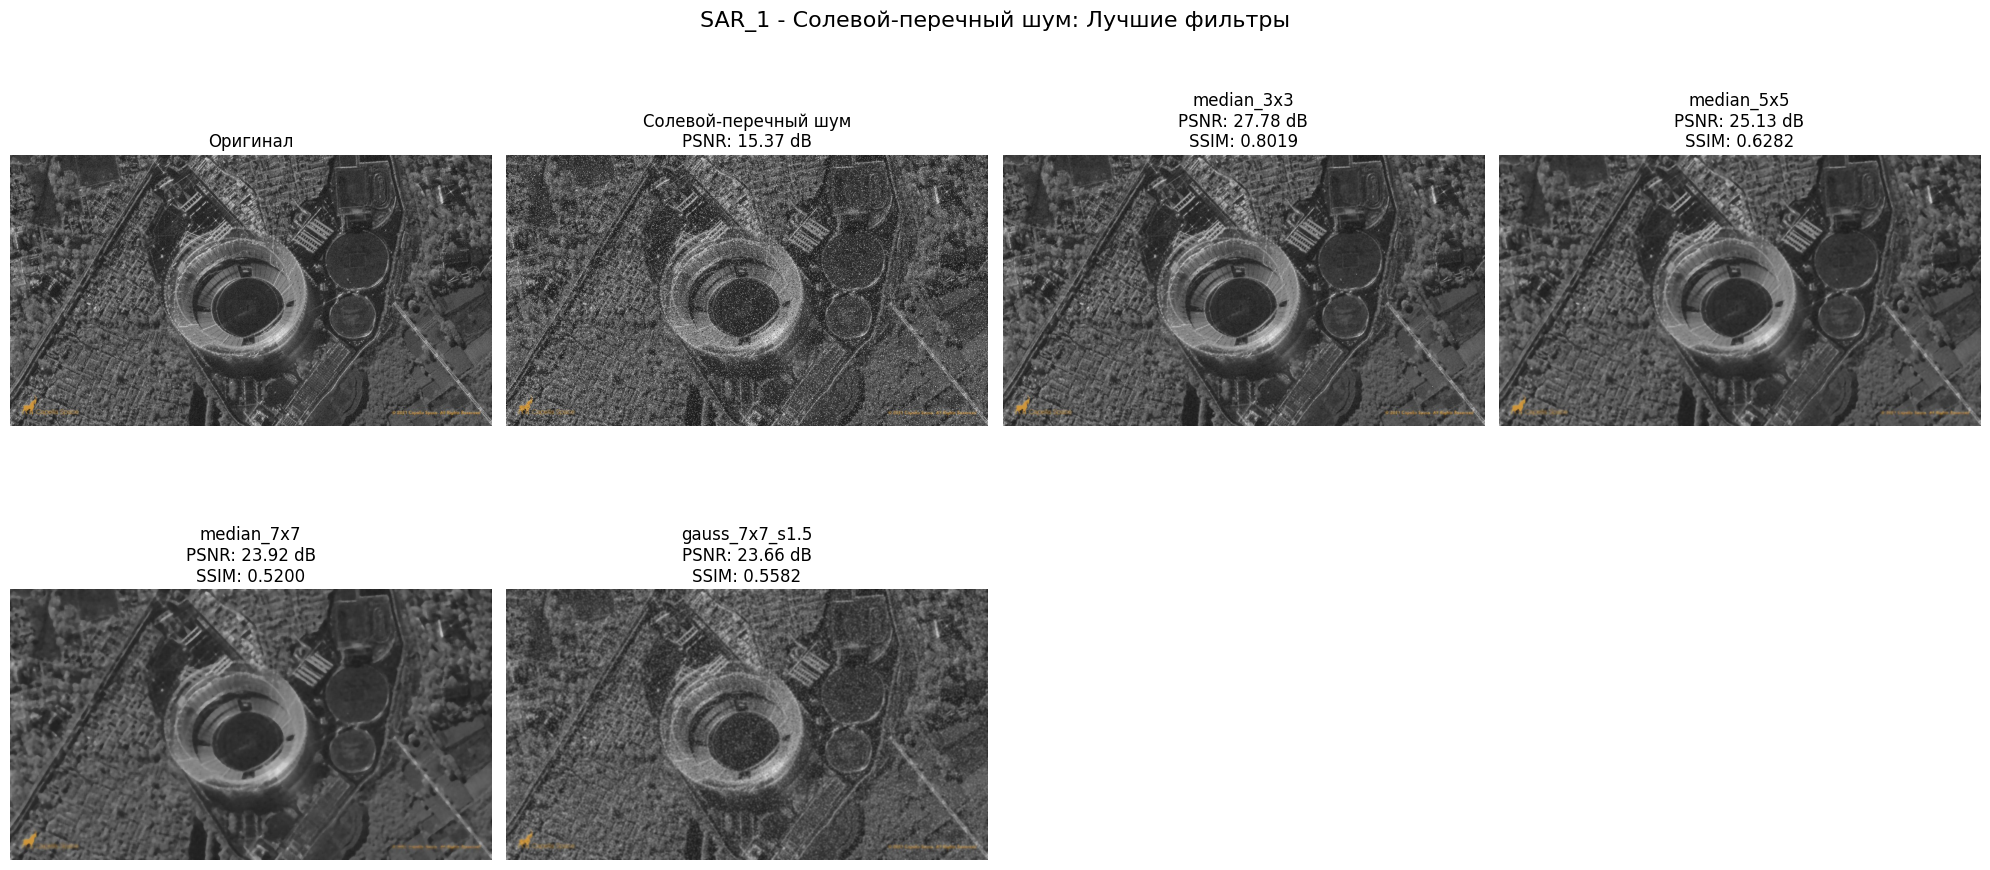

ВЫВОДЫ:
1. Для гауссовского шума обычно лучше всего работают:
   - NLM фильтр с большими параметрами h
   - Билатеральный фильтр с подобранными σ
2. Для солевого-перечного шума:
   - Медианный фильтр с размером 5x5 или 7x7
   - NLM фильтр также показывает хорошие результаты
3. Гауссовский фильтр хуже сохраняет детали
4. Билатеральный фильтр лучше сохраняет границы


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def add_gaussian_noise(image, mean=0, sigma=25):
    """Добавляет гауссовский шум"""
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    return cv2.add(image, gauss)

def add_salt_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    """Добавляет солевой и перечный шум"""
    noisy = image.copy()
    salt_mask = np.random.random(image.shape[:2]) < salt_prob
    pepper_mask = np.random.random(image.shape[:2]) < pepper_prob
    noisy[salt_mask] = 255
    noisy[pepper_mask] = 0
    return noisy

def calculate_psnr(original, filtered):
    """Вычисляет PSNR"""
    mse = np.mean((original.astype(float) - filtered.astype(float)) ** 2)
    return 20 * np.log10(255.0 / np.sqrt(mse)) if mse != 0 else float('inf')

def calculate_ssim(original, filtered):
    """Вычисляет SSIM"""
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
        filtered = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)
    return ssim(original, filtered)

# Функции фильтрации с параметрами
def test_median_filters(noisy_image):
    """Тестирует медианный фильтр с разными параметрами"""
    return {
        'median_3x3': cv2.medianBlur(noisy_image, 3),
        'median_5x5': cv2.medianBlur(noisy_image, 5),
        'median_7x7': cv2.medianBlur(noisy_image, 7),
        'median_9x9': cv2.medianBlur(noisy_image, 9)
    }

def test_gaussian_filters(noisy_image):
    """Тестирует гауссовский фильтр с разными параметрами"""
    return {
        'gauss_3x3_s1': cv2.GaussianBlur(noisy_image, (3, 3), 1),
        'gauss_5x5_s1': cv2.GaussianBlur(noisy_image, (5, 5), 1),
        'gauss_5x5_s2': cv2.GaussianBlur(noisy_image, (5, 5), 2),
        'gauss_7x7_s1.5': cv2.GaussianBlur(noisy_image, (7, 7), 1.5)
    }

def test_bilateral_filters(noisy_image):
    """Тестирует билатеральный фильтр с разными параметрами"""
    return {
        'bilateral_d9_s75': cv2.bilateralFilter(noisy_image, 9, 75, 75),
        'bilateral_d15_s100': cv2.bilateralFilter(noisy_image, 15, 100, 100),
        'bilateral_d9_s150': cv2.bilateralFilter(noisy_image, 9, 150, 150),
        'bilateral_d15_s200': cv2.bilateralFilter(noisy_image, 15, 200, 200)
    }

def test_nlm_filters(noisy_image):
    """Тестирует NLM фильтр с разными параметрами"""
    return {
        'nlm_h10': cv2.fastNlMeansDenoisingColored(noisy_image, None, 10, 10, 7, 21),
        'nlm_h15': cv2.fastNlMeansDenoisingColored(noisy_image, None, 15, 15, 7, 21),
        'nlm_h20': cv2.fastNlMeansDenoisingColored(noisy_image, None, 20, 20, 7, 21),
        'nlm_h10_t11': cv2.fastNlMeansDenoisingColored(noisy_image, None, 10, 10, 11, 21)
    }

def analyze_image(image_path, image_name):
    """Анализирует одно изображение"""
    print(f"АНАЛИЗ: {image_name}")

    
    # Загрузка изображения
    image = cv2.imread(image_path)
    if image is None:
        print(f"Не удалось загрузить {image_path}, создаем тестовое изображение")
        image = np.random.randint(0, 256, (300, 300, 3), dtype=np.uint8)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Добавление шумов
    gaussian_noisy = add_gaussian_noise(image, sigma=35)
    salt_pepper_noisy = add_salt_pepper_noise(image)
    
    # Анализ для каждого типа шума
    for noise_type, noisy in [('Гауссовский', gaussian_noisy), 
                            ('Солевой-перечный', salt_pepper_noisy)]:
        
        print(f"\n {noise_type} шум ")
        print(f"PSNR исходного: {calculate_psnr(image, noisy):.2f} dB")
        
        # Применяем все фильтры
        all_results = {}
        all_results.update(test_median_filters(noisy))
        all_results.update(test_gaussian_filters(noisy))
        all_results.update(test_bilateral_filters(noisy))
        all_results.update(test_nlm_filters(noisy))
        
        # Оцениваем результаты
        results = []
        for name, filtered in all_results.items():
            psnr_val = calculate_psnr(image, filtered)
            ssim_val = calculate_ssim(image, filtered)
            results.append((name, psnr_val, ssim_val, filtered))
        
        # Сортируем по PSNR (лучшие first)
        results.sort(key=lambda x: x[1], reverse=True)
        
        # Выводим топ-5 результатов
        print("\nТоп-5 фильтров:")
        for i, (name, psnr_val, ssim_val, _) in enumerate(results[:5], 1):
            print(f"{i}. {name}: PSNR = {psnr_val:.2f} dB, SSIM = {ssim_val:.4f}")
        
        # Визуализируем лучшие результаты
        plot_results(image, noisy, results[:4], noise_type, image_name)

def plot_results(original, noisy, top_results, noise_type, image_name):
    """Визуализирует результаты"""
    plt.figure(figsize=(20, 10))
    
    # Исходное и зашумленное
    plt.subplot(2, 4, 1)
    plt.imshow(original)
    plt.title('Оригинал')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(noisy)
    plt.title(f'{noise_type} шум\nPSNR: {calculate_psnr(original, noisy):.2f} dB')
    plt.axis('off')
    
    # Лучшие 4 фильтра
    for i, (name, psnr_val, ssim_val, filtered) in enumerate(top_results, 3):
        plt.subplot(2, 4, i)
        plt.imshow(filtered)
        plt.title(f'{name}\nPSNR: {psnr_val:.2f} dB\nSSIM: {ssim_val:.4f}')
        plt.axis('off')
    
    plt.suptitle(f'{image_name} - {noise_type} шум: Лучшие фильтры', fontsize=16)
    plt.tight_layout()
    plt.show()

# Основная программа
if __name__ == "__main__":
    # Анализируем оба изображения
    analyze_image('sar_1.jpg', 'SAR_1')

    
  
    print("ВЫВОДЫ:")
    print("1. Для гауссовского шума обычно лучше всего работают:")
    print("   - NLM фильтр с большими параметрами h")
    print("   - Билатеральный фильтр с подобранными σ")
    print("2. Для солевого-перечного шума:")
    print("   - Медианный фильтр с размером 5x5 или 7x7")
    print("   - NLM фильтр также показывает хорошие результаты")
    print("3. Гауссовский фильтр хуже сохраняет детали")
    print("4. Билатеральный фильтр лучше сохраняет границы")